In [10]:
from pathlib import Path
import pandas as pd
import re
import zipfile
import os
import numpy as np

# Define paths
zip_path = Path("/content/sample_data/Data/archive (1990-2022) (2).zip")
extract_path = Path("/content/sample_data/Data/extracted")
clean_path = Path("/content/sample_data/Data/cleaned")
extract_path.mkdir(exist_ok=True)
clean_path.mkdir(exist_ok=True)


In [11]:
# 2. Extract Zip File
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

csv_files = list(extract_path.rglob("*.csv"))
print(f"Found {len(csv_files)} CSV files.")
csv_files

Found 21 CSV files.


[PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/Gold price INR.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY COMMODITIES_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY PRIVATE BANK_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY ENERGY_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY 100_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY FMCG_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/VIX_History.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY PSU BANK_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY AUTO_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY IT_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY MET

In [12]:
csv_files.remove(Path('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY 100_Data.csv'))
csv_files.remove(Path('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY 50_Data.csv'))
csv_files.remove(Path('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY NEXT 50_Data.csv'))
csv_files

[PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/Gold price INR.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY COMMODITIES_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY PRIVATE BANK_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY ENERGY_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY FMCG_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/VIX_History.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY PSU BANK_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY AUTO_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY IT_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY METAL_Data.csv'),
 PosixPath('/content/sample_data/Data/extracted/archive (1990-2022)/NIFTY O

In [13]:
# Load and stack all files
all_files = csv_files
dfs = []

print(f"Found {len(all_files)} CSV files to process")

Found 18 CSV files to process


In [14]:
for file in all_files:
    sector = file.stem

    try:
        # Load CSV with potential alternative column names
        df = pd.read_csv(file)
        df.columns = [col.strip().lower() for col in df.columns]

        # Detect date column
        date_col = None
        for col in df.columns:
            if "date" in col or "time" in col:
                date_col = col
                break

        if not date_col:
            print(f"Skipping {file} (no date column). Columns: {df.columns.tolist()}")
            continue

        # Rename date column
        df.rename(columns={date_col: "Date"}, inplace=True)

        # Handle Gold price special case
        if "gold price" in sector.lower():
            for price_col in ["inr", "price", "close"]:
                if price_col in df.columns:
                    df = df.rename(columns={price_col: "Close"})
                    df = df.assign(
                        Open=df['Close'],
                        High=df['Close'],
                        Low=df['Close']
                    )
                    break

        # Parse dates
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        df = df.dropna(subset=["Date"])

        if df.empty:
            print(f"Skipping {file} (no valid dates after parsing)")
            continue

        # Detect OHLC columns
        ohlc_columns = {
            "Open": None,
            "High": None,
            "Low": None,
            "Close": None
        }

        for col in df.columns:
            col_lower = col.lower()
            if "open" in col_lower:
                ohlc_columns["Open"] = col
            elif "high" in col_lower:
                ohlc_columns["High"] = col
            elif "low" in col_lower:
                ohlc_columns["Low"] = col
            elif "close" in col_lower or "last" in col_lower or "price" in col_lower:
                ohlc_columns["Close"] = col

        # Create standard columns
        for standard_col, found_col in ohlc_columns.items():
            if found_col and found_col != standard_col:
                df.rename(columns={found_col: standard_col}, inplace=True)
            elif not found_col:
                df[standard_col] = pd.NA

        # Keep only essential columns
        essential_cols = ["Date", "Open", "High", "Low", "Close"]
        df = df[essential_cols].copy()

        # Convert to numeric
        for col in ["Open", "High", "Low", "Close"]:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Custom filling logic
        # 1. Fill Close first (since other fills depend on it)
        df["Close"] = df["Close"].fillna(method="ffill").fillna(method="bfill")

        # 2. Fill Open with previous Close
        df["Open"] = df["Open"].fillna(df["Close"].shift(1))

        # 3. Handle first row if Open is still missing
        df["Open"] = df["Open"].fillna(df["Close"])

        # 4. Fill High with max(Open, Close)
        df["High"] = df["High"].fillna(df[["Open", "Close"]].max(axis=1))

        # 5. Fill Low with min(Open, Close)
        df["Low"] = df["Low"].fillna(df[["Open", "Close"]].min(axis=1))

        # Add identifier columns
        df["Sector"] = sector
        dfs.append(df)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")

/tmp/ipython-input-14-3830835284.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Close"] = df["Close"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-14-3830835284.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Close"] = df["Close"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-14-3830835284.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Close"] = df["Close"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-14-3830835284.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Close"] = df["Close"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipython

In [15]:
dfs

[            Date    Open    High     Low   Close          Sector
 0     1979-01-02    14.7    14.7    14.7    14.7  Gold price INR
 1     1979-01-03    14.7    14.7    14.7    14.7  Gold price INR
 2     1979-01-04    14.8    14.8    14.8    14.8  Gold price INR
 3     1979-01-05    15.1    15.1    15.1    15.1  Gold price INR
 4     1979-01-08    15.1    15.1    15.1    15.1  Gold price INR
 ...          ...     ...     ...     ...     ...             ...
 11374 2022-08-08  1161.8  1161.8  1161.8  1161.8  Gold price INR
 11375 2022-08-09  1169.1  1169.1  1169.1  1169.1  Gold price INR
 11376 2022-08-10  1167.1  1167.1  1167.1  1167.1  Gold price INR
 11377 2022-08-11  1169.7  1169.7  1169.7  1169.7  Gold price INR
 11378 2022-08-12  1167.2  1167.2  1167.2  1167.2  Gold price INR
 
 [11379 rows x 6 columns],
            Date     Open     High      Low    Close                  Sector
 0    2022-08-12  5684.10  5775.75  5674.35  5759.05  NIFTY COMMODITIES_Data
 1    2022-08-11  5728.50

In [16]:
for df in dfs:
    if "gold" in df["Sector"].str.lower().iloc[0]:
        print(f"\n=== Data for Sector: {df['Sector'].iloc[0]} ===")
        print(df[["Date", "Open", "High", "Low", "Close", "Sector"]])


=== Data for Sector: Gold price INR ===
            Date    Open    High     Low   Close          Sector
0     1979-01-02    14.7    14.7    14.7    14.7  Gold price INR
1     1979-01-03    14.7    14.7    14.7    14.7  Gold price INR
2     1979-01-04    14.8    14.8    14.8    14.8  Gold price INR
3     1979-01-05    15.1    15.1    15.1    15.1  Gold price INR
4     1979-01-08    15.1    15.1    15.1    15.1  Gold price INR
...          ...     ...     ...     ...     ...             ...
11374 2022-08-08  1161.8  1161.8  1161.8  1161.8  Gold price INR
11375 2022-08-09  1169.1  1169.1  1169.1  1169.1  Gold price INR
11376 2022-08-10  1167.1  1167.1  1167.1  1167.1  Gold price INR
11377 2022-08-11  1169.7  1169.7  1169.7  1169.7  Gold price INR
11378 2022-08-12  1167.2  1167.2  1167.2  1167.2  Gold price INR

[11379 rows x 6 columns]


In [17]:




# Check if any data was loaded
if not dfs:
    print("No valid data processed. Check error messages above.")
    exit()

merged = pd.concat(dfs, ignore_index=True)
merged = merged.sort_values(["Date", "Sector"])

# Debug: Show all found sectors
print("\nSectors found:")
print(merged["Sector"].unique())

# Save results
merged.to_csv("/content/sample_data/Data/merged.csv", index=False)
print("Saved: merged.csv")


Sectors found:
['Gold price INR' 'VIX_History' 'NIFTY FMCG_Data' 'NIFTY IT_Data'
 'NIFTY BANK_Data' 'NIFTY ENERGY_Data' 'NIFTY MIDCAP 100_Data'
 'NIFTY PHARMA_Data' 'NIFTY AUTO_Data' 'NIFTY COMMODITIES_Data'
 'NIFTY INFRASTRUCTURE_Data' 'NIFTY PSU BANK_Data' 'NIFTY HOUSING_Data'
 'NIFTY INDIA MANUFACTURING_Data' 'NIFTY PRIVATE BANK_Data'
 'NIFTY MEDIA_Data' 'NIFTY METAL_Data' 'NIFTY OIL  GAS_Data']
Saved: merged.csv


#**Imports and Installs**

In [18]:
#!pip install yfinance nltk transformers tensorflow scikit-learn pandas matplotlib seaborn

import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Concatenate
from keras.regularizers import L1L2
from keras.optimizers import Adam
import nltk
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#**Indian Stock Data Processing**

## **2. Load & Preprocess Data**

In [19]:
# Load dataset
data = pd.read_csv("/content/sample_data/Data/merged.csv")
data["date"] = pd.to_datetime(data["Date"])
data.set_index("date", inplace=True)
#data = data.drop(["volume"], axis=1)
# Clean data - convert strings to float (if needed)
for col in ['Open', 'High', 'Low', 'Close']:
    if col in data.columns and isinstance(data[col].iloc[0], str):
        data[col] = data[col].str.replace(',', '').astype(float)

# Display sample
print("\nData Sample:")
print(data.head())


Data Sample:
                  Date  Open  High   Low  Close          Sector
date                                                           
1979-01-02  1979-01-02  14.7  14.7  14.7   14.7  Gold price INR
1979-01-03  1979-01-03  14.7  14.7  14.7   14.7  Gold price INR
1979-01-04  1979-01-04  14.8  14.8  14.8   14.8  Gold price INR
1979-01-05  1979-01-05  15.1  15.1  15.1   15.1  Gold price INR
1979-01-08  1979-01-08  15.1  15.1  15.1   15.1  Gold price INR


## **3. Feature Engineering (TECH+ Component)**

In [20]:
def add_technical_indicators(df):
    # Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    # RSI Calculation
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR Calculation
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    return df

# Add technical indicators
data = add_technical_indicators(data)
data = data.dropna()
print(data.head())

                  Date  Open  High   Low  Close          Sector  SMA_10  \
date                                                                      
1979-01-22  1979-01-22  15.4  15.4  15.4   15.4  Gold price INR   15.00   
1979-01-23  1979-01-23  15.5  15.5  15.5   15.5  Gold price INR   15.06   
1979-01-24  1979-01-24  15.8  15.8  15.8   15.8  Gold price INR   15.16   
1979-01-25  1979-01-25  15.8  15.8  15.8   15.8  Gold price INR   15.26   
1979-01-26  1979-01-26  15.8  15.8  15.8   15.8  Gold price INR   15.38   

               EMA_10        RSI       ATR  
date                                        
1979-01-22  15.127855  62.962963  0.192857  
1979-01-23  15.195518  64.285714  0.200000  
1979-01-24  15.305424  66.666667  0.214286  
1979-01-25  15.395347  62.962963  0.192857  
1979-01-26  15.468920  62.962963  0.192857  


## **5. Prepare Data for BiLSTM**

In [21]:
# Prepare features and target
target = data[['Close']]
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
features = data[numeric_cols].drop(['Close'], axis=1)

print("\nFeatures being used:")
print(features.head())

# Scale data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target)

print("\nScaled features shape:", scaled_features.shape)
print("Scaled target shape:", scaled_target.shape)
seq_cols = 5  # Number of columns for sequence data (e.g., OHLCV)

features_seq = scaled_features[:, :seq_cols]
features_tech = scaled_features[:, seq_cols:]



Features being used:
            Open  High   Low  SMA_10     EMA_10        RSI       ATR
date                                                                
1979-01-22  15.4  15.4  15.4   15.00  15.127855  62.962963  0.192857
1979-01-23  15.5  15.5  15.5   15.06  15.195518  64.285714  0.200000
1979-01-24  15.8  15.8  15.8   15.16  15.305424  66.666667  0.214286
1979-01-25  15.8  15.8  15.8   15.26  15.395347  62.962963  0.192857
1979-01-26  15.8  15.8  15.8   15.38  15.468920  62.962963  0.192857

Scaled features shape: (88419, 7)
Scaled target shape: (88419, 1)


## **6. Create Sequences**

In [22]:
def create_sequences_dual(seq_data, tech_data, target, seq_length=30):
    X_seq, X_tech, y = [], [], []
    for i in range(seq_length, len(seq_data)):
        X_seq.append(seq_data[i-seq_length:i, :])
        X_tech.append(tech_data[i, :])
        y.append(target[i, 0])
    return np.array(X_seq), np.array(X_tech), np.array(y)

X_seq, X_tech, y = create_sequences_dual(features_seq, features_tech, scaled_target)

# Train-test split
train_size = int(0.8 * len(X_seq))

X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
X_train_tech, X_test_tech = X_tech[:train_size], X_tech[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## **7. Build Hybrid BiLSTM with Tech Model**

In [23]:


def build_bilstm_with_tech(input_shape_seq, input_shape_tech, fine_tune=False):
    # === Sequence input (time series prices, etc.)
    seq_input = Input(shape=input_shape_seq, name='sequence_input')
    x = Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=L1L2(l1=0.01, l2=0.01)),
                      name="bi_lstm_1")(seq_input)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(64), name="bi_lstm_2")(x)
    x = Dropout(0.3)(x)

    # === Technical indicators input (Tech+ features)
    tech_input = Input(shape=input_shape_tech, name='tech_input')
    y = Dense(32, activation='relu')(tech_input)

    # === Combine sequence features and technical indicators
    combined = Concatenate()([x, y])

    # === Fully connected layers
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, name='output')(combined)

    # === Build model
    model = Model(inputs=[seq_input, tech_input], outputs=output)

    # === Fine-tuning logic
    if fine_tune:
        # Freeze first BiLSTM layer
        model.get_layer('bi_lstm_1').trainable = False

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

    return model

model = build_bilstm_with_tech(
    input_shape_seq=(X_train_seq.shape[1], X_train_seq.shape[2]),
    input_shape_tech=(X_train_tech.shape[1],),
    fine_tune=False
)

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 30, 256)   │    137,216 │ sequence_input[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ bi_lstm_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bi_lstm_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         96 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 312,033 (1.19 MB)

 Trainable params: 312,033 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

## **8. Train the Model**

Epoch 1/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 329s 145ms/step - loss: 0.2417 - mae: 0.0304 - val_loss: 0.0119 - val_mae: 0.0607
Epoch 2/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 334s 151ms/step - loss: 0.0074 - mae: 0.0210 - val_loss: 0.0111 - val_mae: 0.0473
Epoch 3/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 383s 152ms/step - loss: 0.0074 - mae: 0.0207 - val_loss: 0.0113 - val_mae: 0.0487
Epoch 4/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 384s 152ms/step - loss: 0.0073 - mae: 0.0200 - val_loss: 0.0136 - val_mae: 0.0535
Epoch 5/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 382s 152ms/step - loss: 0.0073 - mae: 0.0199 - val_loss: 0.0112 - val_mae: 0.0444
Epoch 6/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 361s 143ms/step - loss: 0.0073 - mae: 0.0197 - val_loss: 0.0119 - val_mae: 0.0444
Epoch 7/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 336s 152ms/step - loss: 0.0073 - mae: 0.0196 - val_loss: 0.0122 - val_mae: 0.0463
Epoch 8/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 337s 153ms/step - loss: 0.0073 - mae: 0.0191 - val_loss: 0.0113 - val_mae: 0.0451


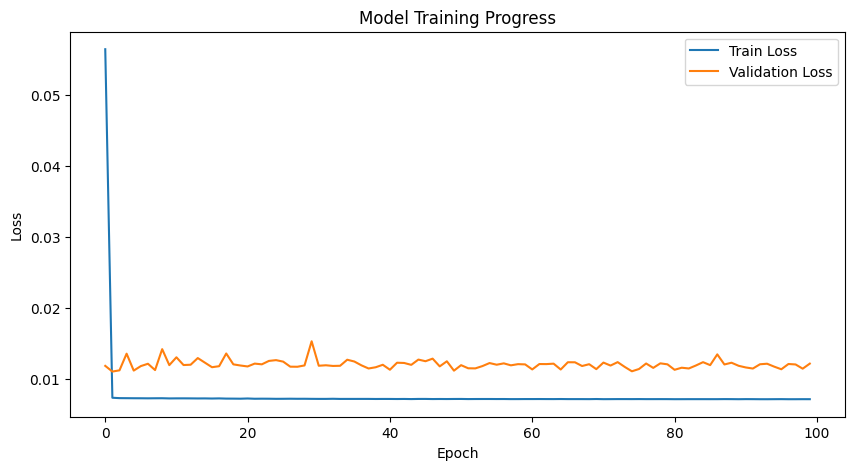

In [24]:
history = model.fit(
    [X_train_seq, X_train_tech],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_test_seq, X_test_tech], y_test),
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## **9. Evaluate Model Performance**

In [25]:
def evaluate_model(actual, predicted):
    metrics = {
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2 Score': r2_score(actual, predicted)
    }
    return metrics

# === Make predictions ===
# Scaled predictions
train_pred_scaled = model.predict([X_train_seq, X_train_tech])
test_pred_scaled = model.predict([X_test_seq, X_test_tech])

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred_scaled.reshape(-1, 1))
test_pred = target_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1))

# Inverse transform true targets
y_train_original = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Optionally also for direct use
y_pred_scaled = model.predict([X_test_seq, X_test_tech])
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance
train_metrics = evaluate_model(y_train_original, train_pred)
test_metrics = evaluate_model(y_test_original, test_pred)


print("\nTraining Metrics:")
print(pd.DataFrame([train_metrics]))

print("\nTest Metrics:")
print(pd.DataFrame([test_metrics]))

2210/2210 ━━━━━━━━━━━━━━━━━━━━ 90s 40ms/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step

Training Metrics:
            MSE        RMSE          MAE  R2 Score
0  7.967459e+06  2822.66882  1497.002885  0.738956

Test Metrics:
            MSE        RMSE          MAE  R2 Score
0  5.495667e+07  7413.27681  4225.724345  0.498787


## **10. Visualize Predictions**

###**1.Prediction Graph**

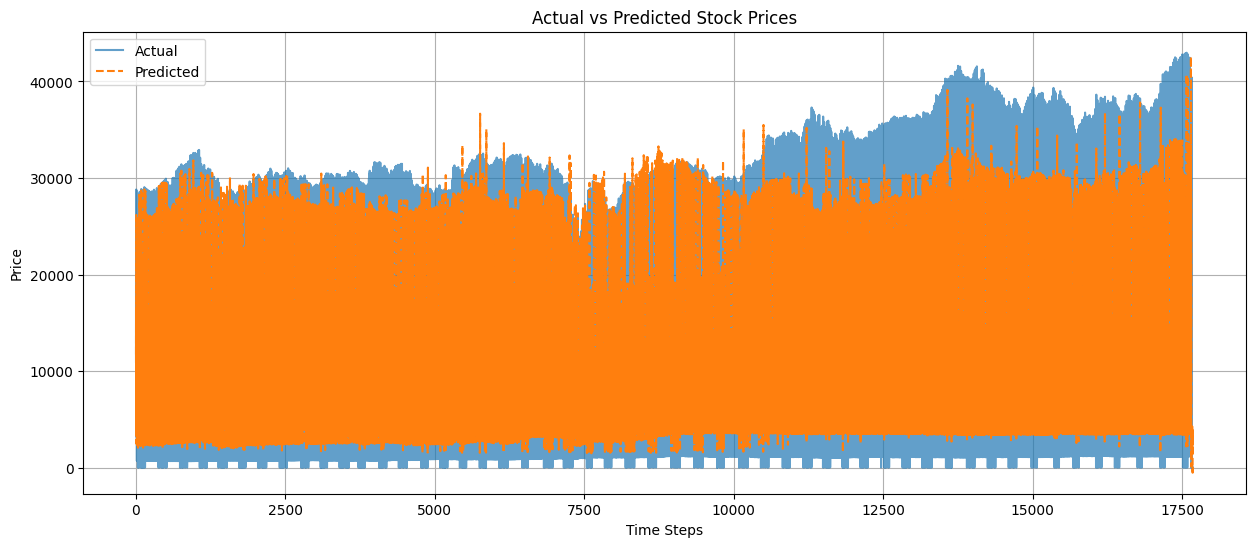

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(target_scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

###**2. Sector Dominance Graph**

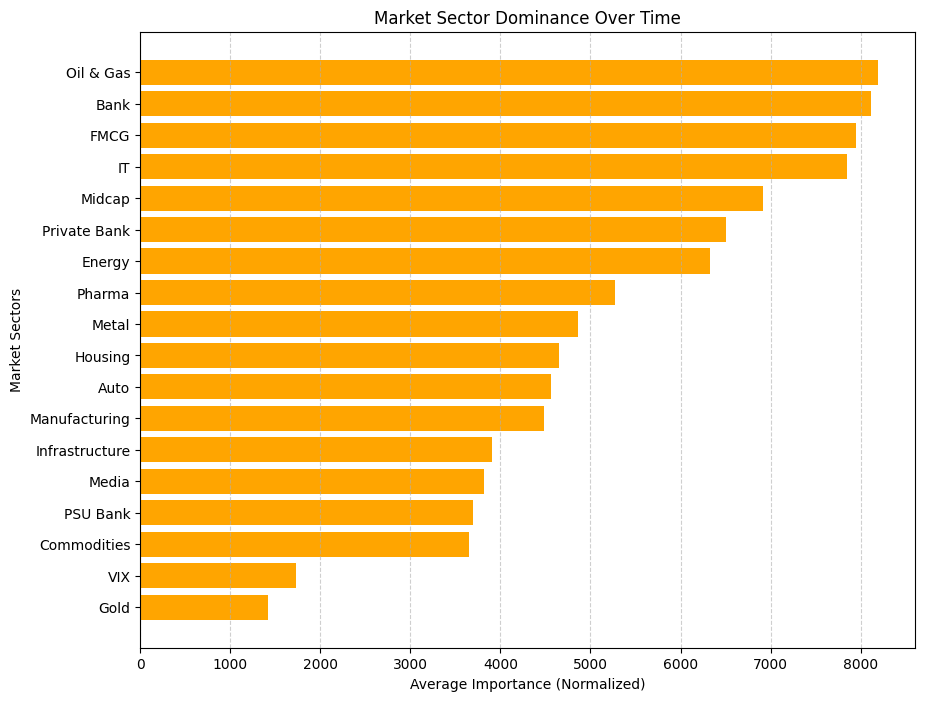

In [27]:

# Rename sector names for clarity
sector_map = {
    'Gold price INR': 'Gold',
    'VIX_History': 'VIX',
    'NIFTY FMCG_Data': 'FMCG',
    'NIFTY IT_Data': 'IT',
    'NIFTY BANK_Data': 'Bank',
    'NIFTY ENERGY_Data': 'Energy',
    'NIFTY MIDCAP 100_Data': 'Midcap',
    'NIFTY PHARMA_Data': 'Pharma',
    'NIFTY AUTO_Data': 'Auto',
    'NIFTY COMMODITIES_Data': 'Commodities',
    'NIFTY INFRASTRUCTURE_Data': 'Infrastructure',
    'NIFTY PSU BANK_Data': 'PSU Bank',
    'NIFTY HOUSING_Data': 'Housing',
    'NIFTY INDIA MANUFACTURING_Data': 'Manufacturing',
    'NIFTY PRIVATE BANK_Data': 'Private Bank',
    'NIFTY MEDIA_Data': 'Media',
    'NIFTY METAL_Data': 'Metal',
    'NIFTY OIL  GAS_Data': 'Oil & Gas',

}

# Replace sectors with clean names
data['Sector_clean'] = data['Sector'].map(sector_map).fillna(data['Sector'])

# Aggregate by sector: mean of technical features over time
sector_importance = data.groupby('Sector_clean')[features.columns].mean().mean(axis=1)

# Sort by importance
sector_importance_sorted = sector_importance.sort_values()

# Plot inverted horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(sector_importance_sorted.index, sector_importance_sorted.values, color='orange')
plt.title('Market Sector Dominance Over Time')
plt.xlabel('Average Importance (Normalized)')
plt.ylabel('Market Sectors')
plt.gca()#.invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


## **11. Future Price Prediction**

In [56]:
def generate_signals(model, X_seq, X_tech, sectors, seq_scaler, target_scaler, close_idx):

    # Get predictions (scaled)
    preds_scaled = model.predict([X_seq, X_tech], verbose=0)

    # Inverse transform predictions
    preds = target_scaler.inverse_transform(preds_scaled.reshape(-1, 1))

    # Extract scaled closing prices
    scaled_closes = X_seq[:, -1, 3].reshape(-1, 1)

    # Inverse transform closing prices using original scaler parameters
    scale_close = seq_scaler.scale_[close_idx]
    min_close = seq_scaler.min_[close_idx]
    current_prices = (scaled_closes - min_close) / scale_close

    # Generate signals
    signals = []
    for sector, current, predicted in zip(sectors, current_prices.flatten(), preds.flatten()):
        if predicted > current * 1.01:
            signal = "Buy"
        elif predicted < current * 0.99:
            signal = "Sell"
        else:
            signal = "Hold"
        signals.append((sector, round(current, 2), round(predicted, 2), signal))

    # Create DataFrame
    df_signals = pd.DataFrame(signals, columns=["Sector", "Current Price", "Predicted Price", "Signal"])
    return df_signals

In [57]:

close_idx = 3
sectors = ["Gold","VIX","FMCG","IT"
,"BANK","ENERGY","MIDCAP","PHARMA"
,"AUTO","COMMODITIES"
,"INFRASTRUCTURE","PSU_BANK","HOUSING"
,"MANUFACTURING","PRIVATE_BANK"
,"MEDIA","METAL","OIL_GAS"]

original_close_idx = 3

# Use the latest test data
X_seq_latest = X_test_seq[-len(sectors):]
X_tech_latest = X_test_tech[-len(sectors):]

# Generate signals
df_signals = generate_signals(
    model,
    X_seq_latest,
    X_tech_latest,
    sectors,
    feature_scaler,
    target_scaler,
    original_close_idx
)

print("\nBuy/Sell Signals for Each Sector:")
print(df_signals)


Buy/Sell Signals for Each Sector:
            Sector  Current Price  Predicted Price Signal
0             Gold       19869.31      3621.649902   Sell
1              VIX       19968.78      3141.459961   Sell
2             FMCG       19968.73      3139.260010   Sell
3               IT       19967.87      3142.570068   Sell
4             BANK       15990.32      3143.110107   Sell
5           ENERGY       15990.14      3592.879883   Sell
6           MIDCAP       12026.27      3592.459961   Sell
7           PHARMA       12025.63      3315.120117   Sell
8             AUTO        8081.89      3920.260010   Sell
9      COMMODITIES        4063.73      3429.560059   Sell
10  INFRASTRUCTURE        4064.62      4331.290039    Buy
11        PSU_BANK          25.49      1487.390015    Buy
12         HOUSING          26.81      1470.920044    Buy
13   MANUFACTURING          27.03      3829.540039    Buy
14    PRIVATE_BANK          26.03      -514.570007   Sell
15           MEDIA          24.49    

#**US Tweet Data process**

##**1. Load Data**

In [60]:
# Load market data
market_df = pd.read_csv("/content/sample_data/Data/stock_yfinance_data.csv")

# Load tweet data
tweets_df = pd.read_csv("/content/sample_data/Data/stock_tweets.csv")

# Compute sentiment polarity
tweets_df['Sentiment'] = tweets_df['Tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Aggregate daily average sentiment per stock
daily_sentiment = tweets_df.groupby(['Date', 'Stock Name'])['Sentiment'].mean().reset_index()

# Merge with market data on Date & Stock Name
merged_df = pd.merge(market_df, daily_sentiment, on=['Date', 'Stock Name'], how='left')
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)

# Drop unneeded columns
merged_df.drop(['Adj Close'], axis=1, inplace=True)



In [61]:
merged_df['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

##**2. Feature Creation**

In [62]:
# Scale per stock symbol
stock_symbols = merged_df['Stock Name'].unique()


for symbol in stock_symbols:
    print(f"\n Processing {symbol}...")

    stock_data = merged_df[merged_df['Stock Name'] == symbol].copy()
    stock_data.drop(['Date', 'Stock Name'], axis=1, inplace=True)


    # Features and target
    X = stock_data.drop(['Close'], axis=1)
    y = stock_data['Close']

    # Scale data
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    scaled_features = feature_scaler.fit_transform(X)
    scaled_target = target_scaler.fit_transform(y.values.reshape(-1, 1))

    print("\nScaled features shape:", scaled_features.shape)
    print("Scaled target shape:", scaled_target.shape)
    seq_cols = 5  # Number of columns for sequence data (e.g., OHLCV)

    features_seq = scaled_features[:, :seq_cols]
    features_tech = scaled_features[:, seq_cols:]


 Processing TSLA...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing MSFT...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing PG...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing META...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing AMZN...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing GOOG...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing AMD...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing AAPL...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing NFLX...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing TSM...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing KO...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)

 Processing F...

Scaled features shape: (252, 5)
Scaled target shape: (252, 1)



##**3. Sequence Creation**

In [63]:
X_seq, X_tech, y = create_sequences_dual(features_seq, features_tech, scaled_target)

# Train-test split
train_size = int(0.8 * len(X_seq))

X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
X_train_tech, X_test_tech = X_tech[:train_size], X_tech[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


##**4. Build Hybrid BiLSTM with Tech Model**

In [64]:
model = build_bilstm_with_tech(
    input_shape_seq=(X_train_seq.shape[1], X_train_seq.shape[2]),
    input_shape_tech=(X_train_tech.shape[1],),
    fine_tune=False
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_1           │ (None, 30, 256)   │    137,216 │ sequence_input[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 256)   │          0 │ bi_lstm_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm_2           │ (None, 128)       │    164,352 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 0)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ bi_lstm_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         32 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,969 (1.19 MB)

 Trainable params: 311,969 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

##**5. Train Model**

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - loss: 3.0926 - mae: 0.3562 - val_loss: 2.7237 - val_mae: 0.2346
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 2.6476 - mae: 0.1737 - val_loss: 2.3791 - val_mae: 0.0475
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 2.3428 - mae: 0.1361 - val_loss: 2.1192 - val_mae: 0.1353
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - loss: 2.0637 - mae: 0.1252 - val_loss: 1.8523 - val_mae: 0.1013
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 1.8117 - mae: 0.1220 - val_loss: 1.6044 - val_mae: 0.0591
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 1.5741 - mae: 0.1162 - val_loss: 1.3892 - val_mae: 0.0982
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 1.3475 - mae: 0.0979 - val_loss: 1.1791 - val_mae: 0.0703
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 1.1517 - mae: 0.1096 - val_loss: 0.9916 - val_mae: 0.0775
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.96

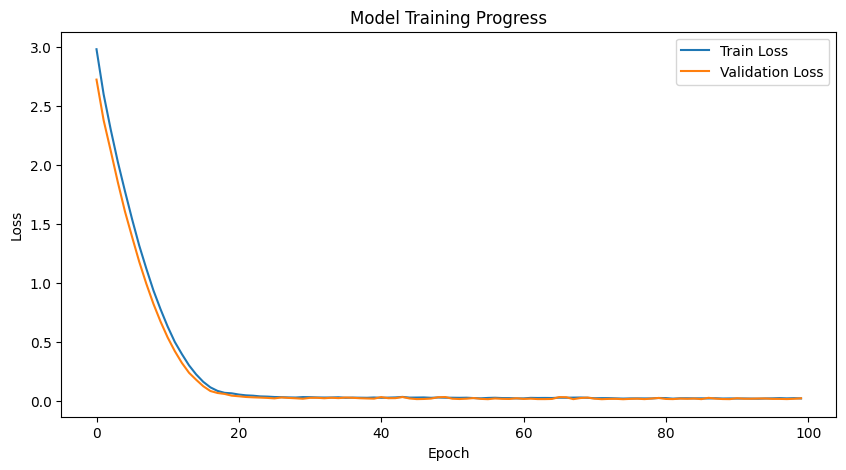

In [65]:
history = model.fit(
    [X_train_seq, X_train_tech],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_test_seq, X_test_tech], y_test),
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

##**6. Model Performance**

In [66]:

# Scaled predictions
train_pred_scaled = model.predict([X_train_seq, X_train_tech])
test_pred_scaled = model.predict([X_test_seq, X_test_tech])

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred_scaled.reshape(-1, 1))
test_pred = target_scaler.inverse_transform(test_pred_scaled.reshape(-1, 1))

# Inverse transform true targets
y_train_original = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Optionally also for direct use
y_pred_scaled = model.predict([X_test_seq, X_test_tech])
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance
train_metrics = evaluate_model(y_train_original, train_pred)
test_metrics = evaluate_model(y_test_original, test_pred)


print("\nTraining Metrics:")
print(pd.DataFrame([train_metrics]))

print("\nTest Metrics:")
print(pd.DataFrame([test_metrics]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Training Metrics:
         MSE     RMSE       MAE  R2 Score
0  11.142977  3.33811  2.601896   0.87562

Test Metrics:
         MSE      RMSE       MAE  R2 Score
0  19.488611  4.414591  4.180044 -0.291364


## **10. Visualize Predictions**

###**1.Prediction Graph**

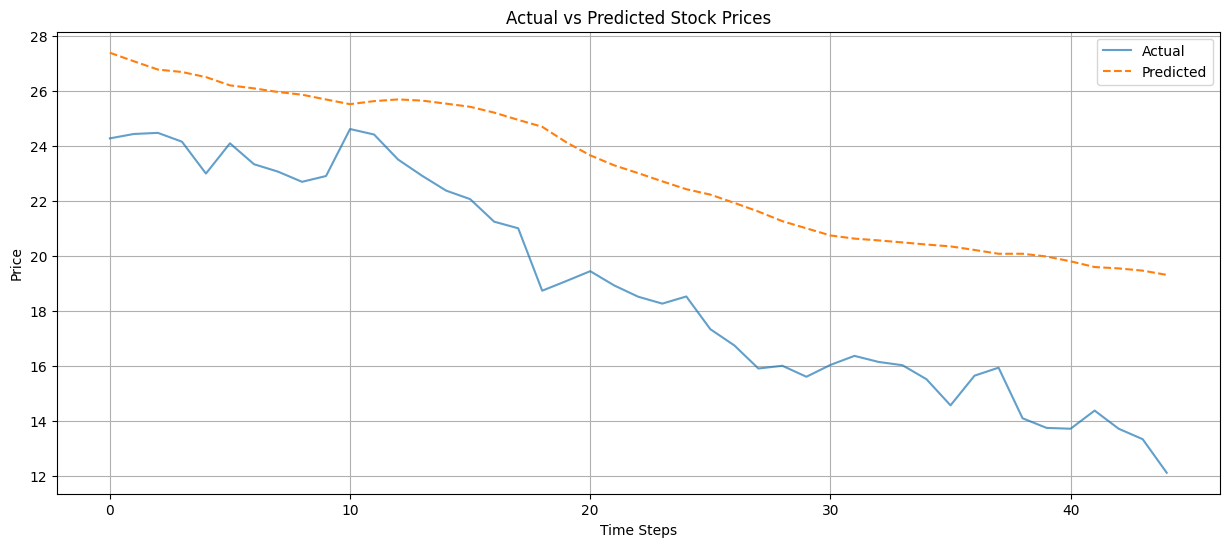

In [67]:
plt.figure(figsize=(15, 6))
plt.plot(target_scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', alpha=0.7)
plt.plot(test_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

###**2. Sector Dominance Graph**

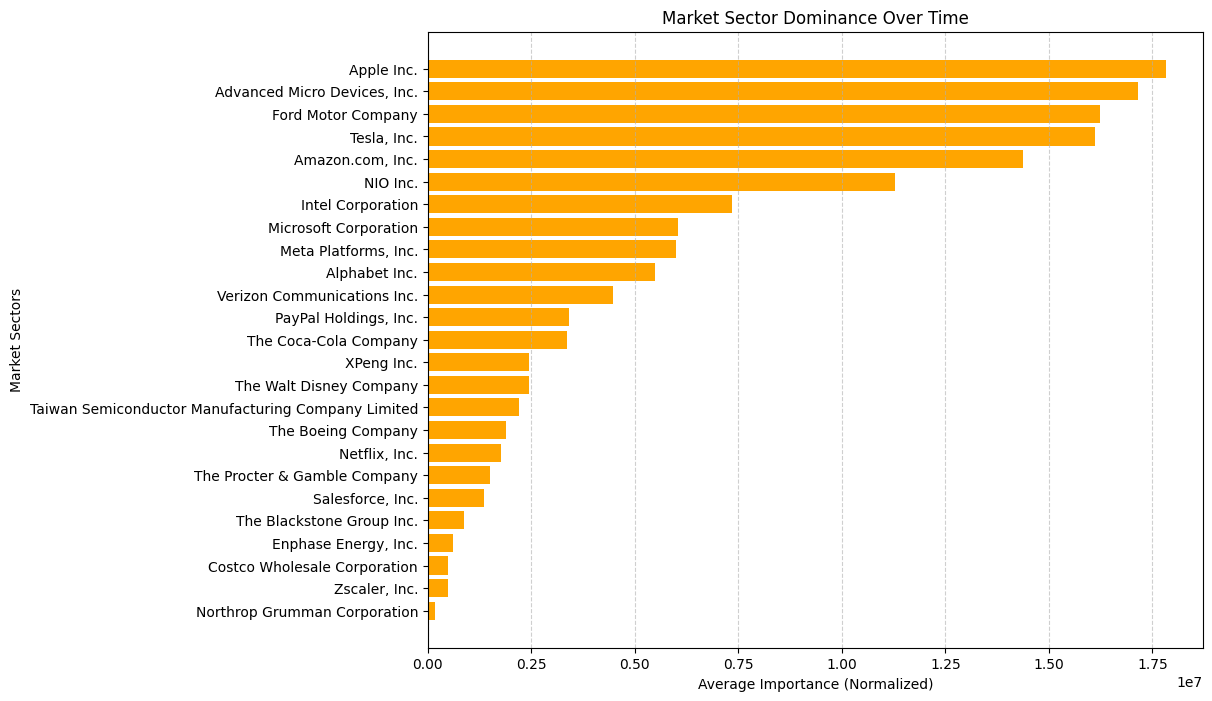

In [68]:

# Rename company names for clarity
company_map = {
    'TSLA': 'Tesla, Inc.',
    'MSFT': 'Microsoft Corporation',
    'PG': 'The Procter & Gamble Company',
    'META': 'Meta Platforms, Inc.',
    'AMZN': 'Amazon.com, Inc.',
    'GOOG': 'Alphabet Inc.',
    'AMD': 'Advanced Micro Devices, Inc.',
    'AAPL': 'Apple Inc.',
    'NFLX': 'Netflix, Inc.',
    'TSM': 'Taiwan Semiconductor Manufacturing Company Limited',
    'KO': 'The Coca-Cola Company',
    'F': 'Ford Motor Company',
    'COST': 'Costco Wholesale Corporation',
    'DIS': 'The Walt Disney Company',
    'VZ': 'Verizon Communications Inc.',
    'CRM': 'Salesforce, Inc.',
    'INTC': 'Intel Corporation',
    'BA': 'The Boeing Company',
    'BX': 'The Blackstone Group Inc.',
    'NOC': 'Northrop Grumman Corporation',
    'PYPL': 'PayPal Holdings, Inc.',
    'ENPH': 'Enphase Energy, Inc.',
    'NIO': 'NIO Inc.',
    'ZS': 'Zscaler, Inc.',
    'XPEV': 'XPeng Inc.'
}
# Replace sectors with clean names
merged_df['Stock Name_clean'] = merged_df['Stock Name'].map(company_map).fillna(merged_df['Stock Name'])

# Aggregate by sector: mean of technical features over time
sector_importance = merged_df.groupby('Stock Name_clean')[X.columns].mean().mean(axis=1)

# Sort by importance
sector_importance_sorted = sector_importance.sort_values()

# Plot inverted horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(sector_importance_sorted.index, sector_importance_sorted.values, color='orange')
plt.title('Market Sector Dominance Over Time')
plt.xlabel('Average Importance (Normalized)')
plt.ylabel('Market Sectors')
plt.gca()#.invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


#**Save Model**

In [56]:

# Load model and scaler
model.save("/content/sample_data/bilstm_with_tech.h5")
# joblib.load("/content/sample_data/target_scaler.pkl")

print("Model and scaler loaded successfully.")


Model and scaler loaded successfully.
